In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy.random as rnd
rnd.seed(42)

from collections import namedtuple

from operator import itemgetter
from itertools import accumulate, chain
from functools import reduce

# Utils

In [2]:
def random_walk(size, mean=0, sd=1, start=0):
    sample = np.cumsum(rnd.normal(loc=mean, scale=sd, size=size))
    return pd.Series(sample + start - sample[0])
    
def slopes(limit, apfreq, mean=0, sd=1):
    counts = np.ceil(rnd.exponential(size=limit, scale=apfreq)).astype(np.int64)
    counts = counts[counts.cumsum() <= limit]
    counts = np.append(counts, limit - counts.sum())
    slopes = rnd.normal(size=len(counts), loc=mean, scale=sd)
    return pd.DataFrame({'count': counts, 'slope': slopes})
    
def piecewise_linear(slopes, start=0):
    series = np.zeros(slopes['count'].sum())
    offset = 0
    for index, row in slopes.iterrows():
        count = int(row['count'])
        series[offset:(count+offset)] = linear(size=int(count), a=row['slope'], b=series[offset-1], series=False)
        offset += count
    return pd.Series(series)    
    
def linear(size, a=1., b=0., series=True):
    arr = a * (np.arange(size) + 1) + b
    return pd.Series(arr) if series else arr

In [3]:
def filter_series(series, filt, drop_na=False):
    win_size = len(filt)
    res =  series.rolling(win_size).apply(lambda w: w.dot(filt), raw=False)
    return res.dropna() if drop_na else res

def diff_series(series, drop_na=False):
    filt = np.array([-1, 1])
    return filter_series(series, filt, drop_na)

# Описание модели

Мы рассмотрим ряд, который имеет следующую модель: $$x_t = x_{t-1} + a_t + \epsilon_t\,$$ где $a_t \sim \mathcal{N}(\mu, \sigma_1)$ --- скорость изменения линейного тренда, которая выбирается случайно из нормального распределения раз в $t \sim \mathcal{Exp}(\lambda)$, $\epsilon_t \sim \mathcal{N}(0, \sigma_2)$

Пусть у нас есть ряд длины $N$. Наша задача предсказать значение в $N+1$ точке. Заметим, что на промежутке с постоянным значением $a_t=a$ (не умаляя общности рассмотрим $t \in [0, T]$): $$x_t = x_0 + a \cdot t + \sum_{i=1}^{t}{\epsilon_i} = x_0 + a \cdot t + W_{t},$$ где $W_t$ --- винеровский процесс. Получается: $x_t - x_{t-1} = a + \epsilon_t,$ и возможно без труда найти оценку угла наклона, необходимо лишь определится с размером окна

In [162]:
Prediction = namedtuple('Prediction', ['Series', 'Prediction', 'Slope', 'Model'])

class LinearForecaster(object):
    def __init__(self, min_window=1, max_window=-1, window_step=1):
        self._window_step = window_step
        self._max_window = max_window
        self._min_window = min_window
        self._fitted_window = None
        self._window_scores = None
        
    @property
    def window_step(self):
        return self._window_step
    
    @window_step.setter
    def window_step(self, new_step):
        self._window_step = new_step
        
    @property
    def max_window(self):
        return self._max_window
    
    @max_window.setter
    def max_window(self, new_max):
        self._max_window = new_max
    
    @property
    def min_window(self):
        return self._min_window
    
    @min_window.setter
    def min_window(self, new_min):
        self._min_window = new_min
    
    @property
    def win_scores(self):
        return self._window_scores
    
    @property
    def fitted_window(self):
        return self._fitted_window
    
    @staticmethod
    def _gen_eval_window(length):
        filt = np.ones(length + 1)
        filt[0:length] /= -length
        return filt
    
    def fit(self, series):
        if series is not pd.Series:
            series = pd.Series(series)
            
        scores = []
        diff = diff_series(series, drop_na=True)
        
        max_window = self._max_window if self._max_window > 0 else len(diff) - 1
        for i in range(self._min_window, self._max_window, self._window_step):
            eval_filt = LinearForecaster._gen_eval_window(i)
            scores.append((i + 1, (filter_series(diff, eval_filt, drop_na=True) ** 2).mean()))
        
        self._window_scores = sorted(scores, key=itemgetter(1))
        self._fitted_window = self._window_scores[0][0]
        
        return self
        
    def predict(self, series, length=1):
        if len(series) < self._fitted_window:
            raise Exception(f"Length of a series must be at least {self._fitted_window} to make a prediction")
        
        if type(series) is not pd.Series:
            series = pd.Series(series)
            
        slope = diff_series(series.tail(self._fitted_window)).mean()
        pred_idx = np.arange(length) + len(series)
        prediction = pd.Series(slope * (np.arange(length) + 1) + series.tail(1).to_list()[0], index=pred_idx)
        return Prediction(Prediction=prediction, Series=series, Slope=slope, Model=self)

In [150]:
class PreviousForecaster(object):
    @property
    def fitted_window(self):
        return 1
    
    def fit(self, series):
        return self
    
    def predict(self, series):
        if type(series) is not pd.Series:
            series = pd.Series(series)
            
        prediction = pd.Series(series.tail(1).to_list(), index=[len(series)])
        return Prediction(Series=series, Prediction=prediction, Slope=None, Model=self)

Как выглядит временно1 ряд и ранзности. Мы зададим небольшую дисперсию у случайных величин $\epsilon_i$, чтобы уменьшить влияние шума для демострации:

In [7]:
dem_sl = slopes(1000, 200, mean=0, sd=1)
dem_ln = piecewise_linear(dem_sl)
dem_rw = random_walk(1000, sd=0.3)
dem_series = dem_ln + dem_rw

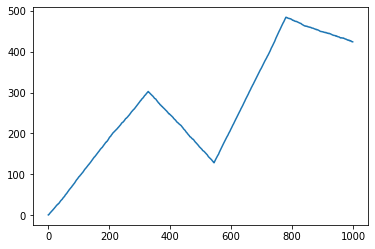

In [8]:
plt.plot(dem_series)

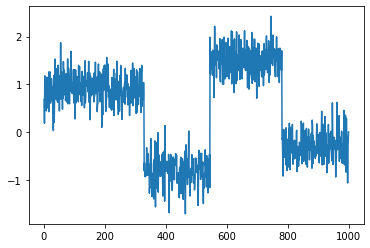

In [9]:
plt.plot(diff_series(dem_series, drop_na=True))

Размеется, определение коэффициента наклона для такого ряда задача несложная: шум не перекрывает тренд ряда. Для экспериментов мы увеличим дисперсию шума: 

In [257]:
size = 1000
sl = slopes(size, 200, sd=0.25)
ln = piecewise_linear(sl)
rw = random_walk(size, sd=1)
series = ln + rw

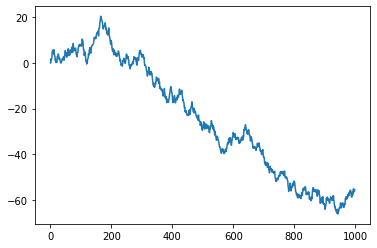

In [258]:
plt.plot(series)

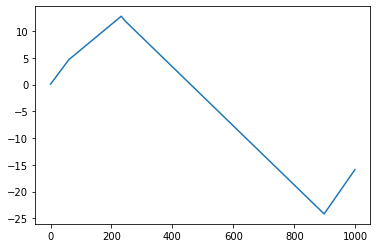

In [259]:
plt.plot(ln)

In [260]:
model = LinearForecaster(min_window=5, max_window=500, window_step=5)
model = model.fit(series)

In [261]:
model.fitted_window

476

In [262]:
pred = model.predict(series)

In [263]:
pred.Slope

-0.056602604045882784

In [223]:
ExperimentResult = namedtuple('ExperimentResult', ['Name', 'AvgMSE', 'AvgWin'])

def run_experiments(size, apfreq, slm=0, slsd=0.1, rwsd=1, test_frac=0.3, repeat=100):
    """
    These are the parameters configuring timeseries generation:
    'size' is the length of a generated time series
    'apfreq' is the APproximate FREQuncy of the slope changing 
    'slm' stands for the 'SLope Mean'
    'slsd' stands for the 'SLope Standard Deviation'
    'rwsd' stands for the 'Random Walk Standard Deviation'
    
    'test_frac' sets the fraction of a series to be used for evaluation of models
    'repeat' sets the number of repetition of the experiment
    
    The result is a tuple of ExperimentResult tuples for LinerPredictor model and PreviousPredictor model
    """
    lin_mse_hist = []
    lin_win_hist = []
    
    prev_mse_hist = []
    
    test_size = int(size * test_frac)
    train_size = size - test_size
    
    def gen_time_series():
        series = piecewise_linear(slopes(size, apfreq, mean=slm, sd=slsd)) + random_walk(size, sd=rwsd)
        return series.head(train_size), series.tail(test_size)
    
    def eval_model(model, train, test):
        win = model.fitted_window
        test = pd.concat([train.tail(win), test])
        diff = test.rolling(window=win+1).apply(lambda s: (s[-1] - model.predict(s[0:win]).Prediction).to_list()[0],
                                                raw=True)
        return (diff ** 2).mean()
        
    def run_experiment():
        train, test = gen_time_series()
        
        lin_model = LinearForecaster(max_window=train_size // 2, window_step=3)
        lin_model = lin_model.fit(train)
        lin_mse = eval_model(lin_model, train, test)
        
        prev_model = PreviousForecaster()
        prev_mse = eval_model(prev_model, train, test)
        
        return lin_mse, lin_model.fitted_window, prev_mse, 1 
        
    for i in range(repeat):
        lin_mse, lin_win, prev_mse, _ = run_experiment()
        lin_mse_hist.append(lin_mse)
        lin_win_hist.append(lin_win)
        prev_mse_hist.append(prev_mse)
    
    return (ExperimentResult(Name='Linear', AvgMSE=np.mean(lin_mse_hist), AvgWin=np.mean(lin_win_hist)),
            ExperimentResult(Name='Prev', AvgMSE=np.mean(prev_mse_hist), AvgWin=1))

In [264]:
run_experiments(1000, 100, slsd=0.5, rwsd=1, test_frac=0.1, repeat=10)

(ExperimentResult(Name='Linear', AvgMSE=1.0810830083577352, AvgWin=69.2),
 ExperimentResult(Name='Prev', AvgMSE=1.3120549489067836, AvgWin=1))